# Import Modules

In [ ]:
!pip install torchview

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os
import torch
from torch import nn
from IPython.display import display
import gc
from warnings import filterwarnings
from sklearn.model_selection import StratifiedKFold
import torchview
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tqdm
from colorama import Fore, Style

gc.collect()

filterwarnings("ignore")

# Config

In [ ]:
class Config:
    features_csv = "/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv"
    responders_csv = "/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv"
    train_parqt = "/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet"
    test_parqt = "/kaggle/input/jane-street-real-time-market-data-forecasting/test.parquet"
    lags_parqt = "/kaggle/input/jane-street-real-time-market-data-forecasting/lags.parquet"
    sample_csv = "/kaggle/input/jane-street-real-time-market-data-forecasting/sample_submission.csv"
    feature_cols = [
    'weight', 'date_id', 'time_id',
    'feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_05', 'feature_06',
    'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 
    'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 
    'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27',
    'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 
    'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 
    'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 
    'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 
    'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62', 
    'feature_63', 'feature_64', 'feature_65', 'feature_66', 'feature_67', 'feature_68', 'feature_69', 
    'feature_70', 'feature_71', 'feature_72', 'feature_73', 'feature_74', 'feature_75', 'feature_76', 
    'feature_77', 'feature_78',
    ]
    max_len = 60
    batch_size = 4
    device = "cuda" if torch.cuda.is_available() else "cpu"
    

# Helper function

In [ ]:
def create_folds(df: pd.DataFrame, target_col: str, num_splits: int = 10, bins: int = None) -> pd.DataFrame:
    """

    Helper function to divide a regression dataset into Stratifield folds
    
    """
    df['kfold'] = -1
    skf = StratitiedKFold(num_splits = num_splits)

    if bins is None:
        bins = int(np.ceil(np.log2(N)) + 1) # Stuggs rule

    df['bins'] = pd.cut(df[target_col], bins = bins, labels = False)

    for idx, (train_idx, val_idx) in enumerate(skf.split(X = df, y = df.bins.values)): 
        df['kfold'] = idx

    # Removing the bins col
    df.drop(['bins'], axis = 1, inplace = True)
    return df


# Loading Dataset

In [ ]:
features_csv = pd.read_csv(Config.features_csv)
features_csv

In [ ]:
responders_csv = pd.read_csv(Config.responders_csv)
responders_csv

In [ ]:
sample_csv = pd.read_csv(Config.sample_csv)
sample_csv.head()

# Creating Model

In [ ]:
class PositionalEncoding(torch.nn.Module):
    def __init__(
        self,
        d_model: int = 10,
        seq_len: int = 10,
        dropout: float = 0.5
    ):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pos_encoding = torch.zeros(seq_len, d_model)
        positions_list = torch.arange(
            0,
            seq_len,
            dtype = torch.float
        ).view(-1, 1)
        division_term = torch.exp(torch.arange(0, d_model, 2).float()) * -(np.log(1e4/d_model))

        # Prevention: For overshoot values that can result in NAN
        positions_list = torch.clamp(positions_list, min=-1e4, max=1e4)
        division_term = torch.clamp(division_term, min=1e-8, max=1e4)

        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        pos_encoding = pos_encoding.unsqueeze(0)
        self.register_buffer("pos_encoding", pos_encoding)

    def forward(
        self,
        token_embedding: torch.tensor
    ) -> torch.tensor:
        return self.dropout(
            token_embedding + self.pos_encoding[:token_embedding.size(1), :]
        )


class Model(torch.nn.Module):
    def __init__(
        self, 
        dropout: float = 0.5,
        d_model: int = 128, 
        num_features: int = 79, 
        seq_len: int = 60,
        nhead: int = 2, 
        num_encoder_layers: int = 3,
        debug: bool = False
    ):
        super().__init__()
        self.debug = debug
        self.embedding = nn.Linear(num_features, d_model)
        if self.debug: print(self.embedding)
        self.position_encoding = PositionalEncoding(
            d_model = d_model,
            seq_len = seq_len,
            dropout = dropout
        )
        if self.debug: print(self.position_encoding)
        self.transformer_enc_layer = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(
                d_model = d_model,
                nhead = nhead,
                dropout = dropout
            ),
            num_layers = num_encoder_layers,
        )
        if self.debug: print(self.transformer_enc_layer)
        self.output_layer = nn.Linear(d_model, 1)
        if self.debug: print(self.output_layer)

    def forward(self, x) -> torch.tensor:
        # x shape: (bs, seq_len, num_features)
        if self.debug: print("x:", x.shape, x)
        x = self.embedding(x) # (bs, seq_len, d_model)
        if self.debug: print("self.embedding(x): ", x.shape, x)
        x = self.position_encoding(x) # (bs, seq_len, d_model)
        if self.debug: print("self.position_encoding(x): ", x.shape, x)
        x = x.permute(1, 0, 2) # (seq_len, bs, d_model)
        if self.debug: print("x.permute(1, 0, 2): ", x.shape, x)
        x = self.transformer_enc_layer(x) # (seq_len, batch_size, d_model)
        if self.debug: print("self.transformer_enc_layer(x): ", x.shape, x)
        x = x[-1, :, :] # (bs, d_model)
        if self.debug: print("x[-1, :, :]: ", x.shape, x)
        y = self.output_layer(x) # (bs, 1)
        if self.debug: print("y: ", y.shape, y)
        return y

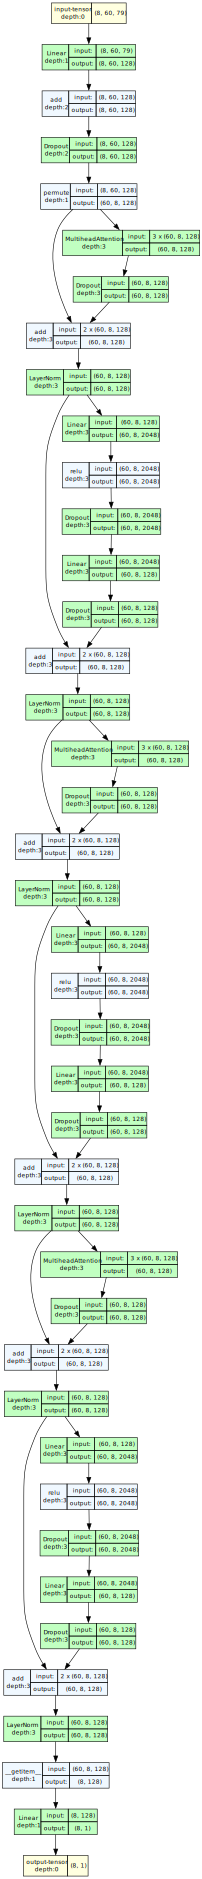

In [46]:
# Visualizing the model
model = Model()
model_graph = torchview.draw_graph(model, input_size=(8, 60, 79), device=Config.device)
model_graph.visual_graph

In [47]:
# Removing from memory
model = None
del model
gc.collect()

1530

In [48]:
df = pd.read_parquet("/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet")
df

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,0,0,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.851033,...,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
1,0,0,7,1.370613,NaN,NaN,NaN,NaN,NaN,0.676961,...,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639
2,0,0,9,2.285698,NaN,NaN,NaN,NaN,NaN,1.056285,...,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
3,0,0,10,0.690606,NaN,NaN,NaN,NaN,NaN,1.139366,...,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
4,0,0,14,0.440570,NaN,NaN,NaN,NaN,NaN,0.955200,...,3.418133,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.000000,-3.572820,-1.089123,-5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944205,169,848,19,3.438631,NaN,NaN,NaN,NaN,NaN,-0.028087,...,-0.166964,0.983339,-0.669860,0.272615,-3.676842,-1.221126,1.070584,0.465345,0.207483,0.874975
1944206,169,848,30,0.768528,NaN,NaN,NaN,NaN,NaN,-0.022584,...,-0.352810,0.992615,0.961595,1.089402,0.796034,0.488380,1.846634,-0.088542,-0.008324,-0.153451
1944207,169,848,33,1.354696,NaN,NaN,NaN,NaN,NaN,-0.024804,...,-0.239716,1.701618,0.757672,-5.000000,-3.174266,-1.110790,-3.349107,-0.407801,-0.185842,-0.931004
1944208,169,848,34,1.021797,NaN,NaN,NaN,NaN,NaN,-0.016138,...,-0.442859,-2.036891,-0.064228,1.919665,1.827681,0.872019,3.248694,0.254584,0.090288,0.434726


In [51]:
class Pipeline:
    def __init__(
        self,
        data: pd.DataFrame,
        seq_len: int,
        folds: int,
        target_col: str,
        feature_cols: list[str],
    ):
        self.data = data
        self.seq_len = seq_len 
        self.folds = folds 
        self.target_col = target_col 
        self.feature_cols = feature_cols

        self.label = self.data[self.target_col]
        self.data = self.data[self.feature_cols]
        
        # Filling nan values with mean
        self.data.fillna(self.data.mean(), inplace = True)

    def create_sequences(self):
        """

        Method to create {seq_len} sequences for all the features
        
        """
        features, labels = [], []
        N = len(self.data)
        colored_desc = f"{Fore.GREEN}Making windows{Style.RESET_ALL}"
        with tqdm.tqdm(total = N, desc = colored_desc, unit = "row(s)", ncols = 100) as pbar:
            for i in range(N):
                # Reversing the values for padding
                window_values = self.data.values.tolist()[i-self.seq_len: i][::-1]
                window_labels = self.label.values.tolist()[i-self.seq_len: i][::-1]
    
                # Padding windows
                while len(window_values) < self.seq_len: 
                    window_values.append([-999]*len(self.feature_cols))
                    window_labels.append(-999)
    
                # Re-Reversing the values for getting padded values
                window_values = window_values[::-1]
                window_labels = window_labels[::-1]
    
    
                features.append(window_values)
                labels.append(window_labels)
                pbar.update(1)

        return features, labels
    
    def pipe(self):
        """

        Method to run the preprocessing pipeline
        
        """
        pass
    
    def __del__(self):
        self.data = data
        self.seq_len = seq_len 
        self.folds = folds 
        self.target_col = target_col 
        self.feature_cols = feature_cols
        gc.collect()
        

In [ ]:
features, labels = Pipeline(df, 60, 5, 'responder_6', Config.feature_cols).create_sequences()

Making windows:   0%|                                               | 0/1944210 [00:00<?, ?row(s)/s]Exception ignored in: <function Pipeline.__del__ at 0x7db4e5fdd2d0>
Traceback (most recent call last):
  File "/tmp/ipykernel_24/1775212211.py", line 62, in __del__
NameError: name 'data' is not defined


# PQT Files

In [73]:
file_path = f"/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id={0}/part-0.parquet"
df = pd.read_parquet(file_path)
df[
    Config.feature_cols + ["responder_6"]
].head()

,weight,date_id,time_id,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,...,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6
0,3.889038,0,0,NaN,NaN,NaN,NaN,NaN,0.851033,0.242971,...,-1.022690,0.152241,-0.659864,NaN,NaN,-0.261412,-0.211486,-0.335556,-0.281498,0.775981
1,1.370613,0,0,NaN,NaN,NaN,NaN,NaN,0.676961,0.151984,...,-1.052685,-0.393726,-0.741603,NaN,NaN,-0.281207,-0.182894,-0.245565,-0.302441,0.703665
2,2.285698,0,0,NaN,NaN,NaN,NaN,NaN,1.056285,0.187227,...,-0.863230,-0.241892,-0.709919,NaN,NaN,0.377131,0.300724,-0.106842,-0.096792,2.109352
3,0.690606,0,0,NaN,NaN,NaN,NaN,NaN,1.139366,0.273328,...,-0.530602,4.765215,0.571554,NaN,NaN,-0.226891,-0.251412,-0.215522,-0.296244,1.114137
4,0.440570,0,0,NaN,NaN,NaN,NaN,NaN,0.955200,0.262404,...,-1.141761,0.099631,-0.661928,NaN,NaN,3.678076,2.793581,2.618250,3.418133,-3.572820
